In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, Embedding, BatchNormalization, Activation, Dense, Concatenate , Flatten, LSTM, Input, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import activations, Model
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

In [18]:
drive.mount('/content/drive')

X_answer = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/separate_data/answer.csv', delimiter=',')
X_question = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/separate_data/question.csv', delimiter=',')

X = np.concatenate([X_answer, X_question], axis=1)
Y = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/separate_data/labels.csv', delimiter=',')

print(X_answer.shape)
print(X_question.shape)
print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(519, 59)
(519, 32)
(519, 3)
(347, 91) (347, 3)
(172, 91) (172, 3)


[0 1 2]
{0: 0.7274633123689728, 1: 2.753968253968254, 2: 0.7922374429223744}


<BarContainer object of 3 artists>

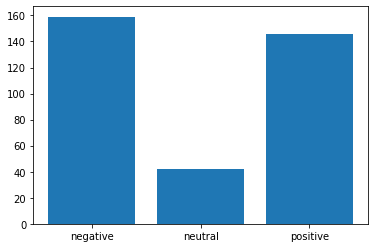

In [21]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

labels =  [np.where(r==1)[0][0] for r in Y_train]

labels_dict  = {'negative' : labels.count(0),
                'neutral': labels.count(1),
                'positive': labels.count(2)}

print(np.unique(labels))

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(labels),
                                        y = labels                                                 
                                    )
class_weights = dict(zip(np.unique(labels), class_weights))

print(class_weights)

plt.bar(list(labels_dict.keys()), list(labels_dict.values()))

In [22]:
def draw_confusion_matrix(y_predict):
  "gets the one-hot-encoded y_predict and draw confusion matrix for y_test and y_predict"
  y_pred = [np.where(r==1)[0][0] for r in y_predict]
  y_test = [np.where(r==1)[0][0] for r in Y_test]

  confusion = confusion_matrix(y_test, y_pred)
  # print('Confusion Matrix\n')
  # print(confusion)

  ax = sns.heatmap(confusion/np.sum(confusion), annot=True, cmap='Blues')
  ax.set_xlabel('\nPredicted sentiment Category')
  ax.set_ylabel('Actual senntiment Category ');
  ax.xaxis.set_ticklabels(['negative','neutral', 'positive'])
  ax.yaxis.set_ticklabels(['negative','neutral', 'positive'])

  plt.show()

In [23]:
x_answer_train = X_train[:, :59]
print(len(x_answer_train), len(x_answer_train[0]))

x_question_train = X_train[: , 59:]
print(len(x_question_train), len(x_question_train[0]))

x_answer_test = X_test[:, :59]
print(len(x_answer_test), len(x_answer_test[0]))

x_question_test = X_test[: , 59:]
print(len(x_question_test), len(x_question_test[0]))

347 59
347 32
172 59
172 32


In [5]:
x_1 = x_answer_train.reshape(1, 347 , 59)
x_2 = x_question_train.reshape(1, 347 , 32)

In [6]:
initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

In [24]:
latent_dim=128

#LSTM 1 
inputs_1 = Input(shape=(59,)) 
enc_emb_1 = Embedding(386, latent_dim)(inputs_1) 
lstm1 = LSTM(64, dropout=0.2, recurrent_dropout=0.2) 
output1 = lstm1(enc_emb_1) 

#LSTM 1 
inputs_2 = Input(shape=(32,)) 
enc_emb_2 = Embedding(190, latent_dim)(inputs_2) 
lstm2 = LSTM(64, dropout=0.2, recurrent_dropout=0.2) 
output2 = lstm2(enc_emb_2) 


merge = Concatenate (axis=-1)([output1, output2])
dropout_1 = Dropout(0.4)
dense_1 = Dense(64)(merge)
dense = Dense(3, activation='softmax' ,bias_initializer=initializer)
out = dense(dense_1)

model = Model([inputs_1, inputs_2], out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy])
print(model.summary()) 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 59)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 59, 128)      49408       ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 32, 128)      24320       ['input_4[0][0]']                
                                                                                            

In [25]:
epochs = 50
batch_size = 128

checkpoint_path = "/content/drive/My Drive/thesis/code/concatenated_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

history = model.fit([x_answer_train, x_question_train], 
                    Y_train, 
                    epochs=epochs,
                    shuffle = False,
                    batch_size = batch_size, 
                    validation_split=0.25,
                    class_weight=class_weights, 
                    callbacks=[ModelCheckpoint(filepath=checkpoint_path, monitor='val_categorical_accuracy',mode='max',save_best_only=True)], 
                    verbose=0)

In [26]:
print("best train accuracy : " , history.history['categorical_accuracy'][np.argmax(history.history['categorical_accuracy'])], "in epoch : ",np.argmax(history.history['categorical_accuracy']))
print("best validation accuracy : " , history.history['val_categorical_accuracy'][np.argmax(history.history['val_categorical_accuracy'])], "in epoch : ",np.argmax(history.history['val_categorical_accuracy']))

best train accuracy :  0.9884615540504456 in epoch :  37
best validation accuracy :  0.7241379022598267 in epoch :  33


In [27]:
best_cassifier = load_model(checkpoint_path)
accr = best_cassifier.evaluate([x_answer_test, x_question_test],Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6/6 [==============================] - 1s 17ms/step - loss: 0.7333 - categorical_accuracy: 0.7093
Test set
  Loss: 0.733
  Accuracy: 0.709


# Analysis

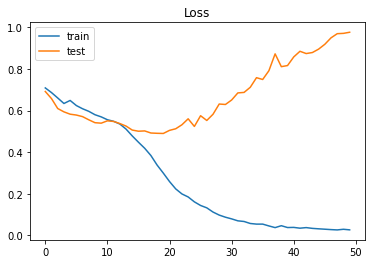

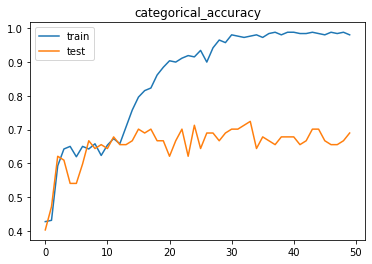

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('categorical_accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show()

6/6 [==============================] - 1s 16ms/step


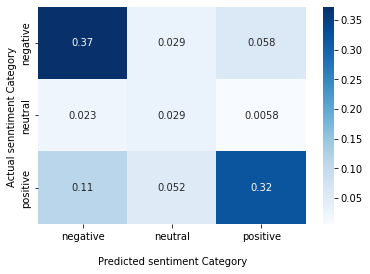

In [32]:
Y_predict = model.predict([x_answer_test, x_question_test])
Y_predict = to_categorical(np.argmax(Y_predict, axis=1), 3)
draw_confusion_matrix(Y_predict)

In [33]:
from sklearn.metrics import classification_report

target_names = ["negative" , "neutral" , "positive"]

print(classification_report(Y_test, Y_predict, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.74      0.81      0.77        79
     neutral       0.26      0.50      0.34        10
    positive       0.83      0.66      0.74        83

   micro avg       0.72      0.72      0.72       172
   macro avg       0.61      0.66      0.62       172
weighted avg       0.76      0.72      0.73       172
 samples avg       0.72      0.72      0.72       172

